In [3]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [4]:
# Inicialización
import torch

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Definición de constantes 
import os

# esto es para que funcione matplotlib 
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

BATCH_SIZE = 4
EPOCHS = 10
DATASET_DIR = './data/'
MODELS_DIR = 'models/'
print(torch.cuda.get_device_name())

Using cuda device
NVIDIA GeForce RTX 3060


In [5]:
from torchvision.io import read_image

sizes = []
for image in os.listdir('./data/images/colored_labels'):
    sizes.append(read_image("./data/images/colored_labels/" + image).shape)
print("Range for inputs with segmentation: ")
print(max(sizes))
print(min(sizes))

sizes = []
for image in os.listdir('./data/images/text_labels'):
    sizes.append(read_image("./data/images/text_labels/" + image).shape)
print("Range for inputs with txt: ")
print(max(sizes))
print(min(sizes))


Range for inputs with segmentation: 
torch.Size([3, 873, 550])
torch.Size([3, 801, 550])
Range for inputs with txt: 
torch.Size([3, 877, 550])
torch.Size([3, 786, 550])


No necesito que me prediga el color exacto de cada categoría, si sabe que es un vestido, luego busco en la tabla su color y listo. 

Para ello, en la siguiente celda creo un codificador y decodificador de one hot a una de las clases, cada una asociada a un color:

In [6]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import joblib

classes = pd.read_csv(DATASET_DIR + "/class_dict.csv")

# Si tuvieramos que volver a crear el codificar las líneas serían las siguientes:
#encoder = OneHotEncoder(sparse=False) #joblib.dump(encoder,"one_hot_encoder.joblib")
#codes = encoder.fit_transform(classes["class_name"].values.reshape(-1,1))
encoder = joblib.load('one_hot_encoder.joblib')
codes = encoder.transform(classes["class_name"].values.reshape(-1,1))
codigo_none = codes[0]
codigo_accesorios = codes[1]

uncoded = encoder.inverse_transform([codigo_none, codigo_accesorios])
print("one hot de nada y de accesorios devuelve segun encoder: ", uncoded)

print("Sus colores segun el dataframe: \n", classes[classes["class_name"].isin(uncoded.flatten())][["r","g","b"]])

one hot de nada y de accesorios devuelve segun encoder:  [['none']
 ['accessories']]
Sus colores segun el dataframe: 
     r   g   b
0  69   6  90
1  70  12  95


Dataset para cargar imágenes:

In [7]:
import numpy as np

encoder = OneHotEncoder(sparse=False)
codes = encoder.fit_transform(classes["class_name"].values.reshape(-1,1)).astype(np.uint8)

encoded_df = pd.concat([classes, pd.Series(list(codes[:]))], axis=1).rename(columns={0: "One-hot"}, inplace=False)
encoded_df["array_value"] = encoded_df[["r","g","b"]].apply(lambda x: np.array([x.r, x.g, x.b], dtype=np.uint8), axis=1)
encoded_df["tensor_value"] = encoded_df[["r","g","b"]].apply(lambda x: torch.tensor([x.r, x.g, x.b], dtype=torch.uint8), axis=1)
encoded_df

C:\Users\Usuario\interpreters\python\aaiv\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,class_name,r,g,b,One-hot,array_value,tensor_value
0,none,69,6,90,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[69, 6, 90]","[tensor(69, dtype=torch.uint8), tensor(6, dtyp..."
1,accessories,70,12,95,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[70, 12, 95]","[tensor(70, dtype=torch.uint8), tensor(12, dty..."
2,bag,71,18,101,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[71, 18, 101]","[tensor(71, dtype=torch.uint8), tensor(18, dty..."
3,belt,72,25,107,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[72, 25, 107]","[tensor(72, dtype=torch.uint8), tensor(25, dty..."
4,blazer,72,30,112,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[72, 30, 112]","[tensor(72, dtype=torch.uint8), tensor(30, dty..."
5,blouse,72,35,116,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[72, 35, 116]","[tensor(72, dtype=torch.uint8), tensor(35, dty..."
6,bodysuit,71,40,120,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[71, 40, 120]","[tensor(71, dtype=torch.uint8), tensor(40, dty..."
7,boots,70,47,124,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[70, 47, 124]","[tensor(70, dtype=torch.uint8), tensor(47, dty..."
8,bra,69,52,127,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[69, 52, 127]","[tensor(69, dtype=torch.uint8), tensor(52, dty..."
9,bracelet,68,57,130,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[68, 57, 130]","[tensor(68, dtype=torch.uint8), tensor(57, dty..."


In [8]:
encoded_df["byte_value"] = encoded_df["array_value"].apply(lambda x: x.tobytes())

array_to_onehot = encoded_df[["byte_value", "One-hot"]].set_index('byte_value').to_dict()["One-hot"]
array_to_onehot

{b'E\x06Z': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 b'F\x0c_': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 b'G\x12e': array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 b'H\x19k': array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 b'H\x1ep': array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       

In [9]:

from torchvision.transforms import InterpolationMode
from numpy import int64
from PIL import Image
import random
    
class CustomClothingDataset(Dataset):
    def __init__(self, root_dir, input_dir='images/colored_labels', 
                 labels_dir='labels/processed_pixel_labels',
                 transform_input=transforms.Compose([
                     transforms.Resize((512, 224), interpolation=InterpolationMode.NEAREST), #size mayor de las imagenes, para todas iguales sin perder información, esta ligeramente reducido para ser divisible por 16 (necesario para U-net
                     transforms.Lambda(lambda x: x / 255), # reescalo de 0 a 1
                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),# normalizo
                 ]),
                 transform_labels=transforms.Compose([
                    transforms.Resize((512, 224), interpolation=InterpolationMode.NEAREST),
                 ]),
                 transform_augmentation = transforms.RandomHorizontalFlip(p=1)            
                 ):
                        
        self.root_dir = root_dir
        self.input_dir = input_dir
        self.labels_dir = labels_dir
        self.transform_input = transform_input
        self.transform_labels = transform_labels
        self.transform_augmentation = transform_augmentation
        self.image_files = os.listdir(os.path.join(root_dir, self.input_dir))
        self.label_files = os.listdir(os.path.join(root_dir, self.labels_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        input = read_image(os.path.join(self.root_dir, self.input_dir, self.image_files[idx]))
        label = torch.load(os.path.join(self.root_dir, self.labels_dir, self.label_files[idx])).permute(2,0,1) # el preprocesado de labels se llevo a cabo anteriormente
        if self.transform_input:        
            input = self.transform_input(input)
        if self.transform_labels:
            label = self.transform_labels(label)
        if self.transform_augmentation and random.choice([True, False]):
            return self.transform_augmentation(input), self.transform_augmentation(label)
        return input, label
            


Revertimos la codificacion para afianzar que es correcta:

In [10]:
x = torch.tensor([[1]*3,[0]*3,[4]*3])


def apply_along_axis(function, x, axis: int = 0):
     return torch.stack([
       function(x_i) for x_i in torch.unbind(x, dim=axis)
    ], dim=axis)

def fun(pixel):
    one_hot = array_to_onehot[pixel]
    return one_hot





In [11]:
dataset = CustomClothingDataset(root_dir=DATASET_DIR) 
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE) 

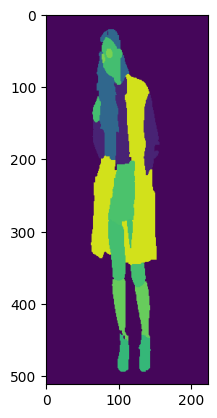

In [46]:
import numpy as np
import matplotlib.pyplot as plt

onehot_to_array = {v.tobytes(): k for k, v in array_to_onehot.items()}
def decode_image(image):
    return np.apply_along_axis(lambda pixel: np.frombuffer(onehot_to_array[pixel.tobytes()], dtype=np.uint8), 0, np.array(image, np.uint8)).transpose(1,2,0)
    


label = CustomClothingDataset(root_dir=DATASET_DIR).__getitem__(0)[1]
plt.imshow(decode_image(label))

In [13]:

image = Image.open(r"C:\Users\Usuario\PycharmProjects\aaiv\ClothingProject\data\labels\pixel_level_labels_colored\0001.png")


label = np.asarray(image, dtype=np.uint8)
codified = np.apply_along_axis(lambda pixel: array_to_onehot[pixel.tobytes()], 2, label)
label_ = torch.tensor(codified, dtype=torch.uint8)


In [14]:
label_.permute(2,0,1).shape

torch.Size([59, 832, 550])

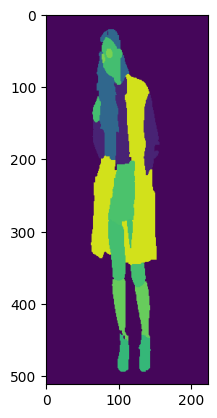

In [15]:
ca = label_.permute(2, 0, 1)
ca = CustomClothingDataset(root_dir=DATASET_DIR).__getitem__(0)[1]
plt.imshow(decode_image(ca))

In [16]:
#label = torch.load(r"C:\Users\Usuario\PycharmProjects\aaiv\ClothingProject\data\labels\processed_pixel_labels\0001.pt")

# Reshape to a 2D array where each row is an RGB triplet
reshaped_image = label_.view(59, -1).T

# Get unique rows (unique colors)
unique_colors = torch.unique(reshaped_image, dim=0)

print("Number of unique colors:", unique_colors.shape[0])
print("Unique colors:", unique_colors)

Number of unique colors: 206
Unique colors: tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 1],
        [0, 0, 0,  ..., 0, 1, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)


In [17]:
for color in unique_colors:
    if not any([torch.all(torch.eq(color, torch.tensor(array))) for array in array_to_onehot.values()]):
        print(color)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.uint8)
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0], dtype=torch.uint8)
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0], dtype=torch.uint8)
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0], dtype=torch.uint8)
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Cantidad de imágenes:  1004


C:\Users\Usuario\interpreters\python\aaiv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([59, 512, 224])


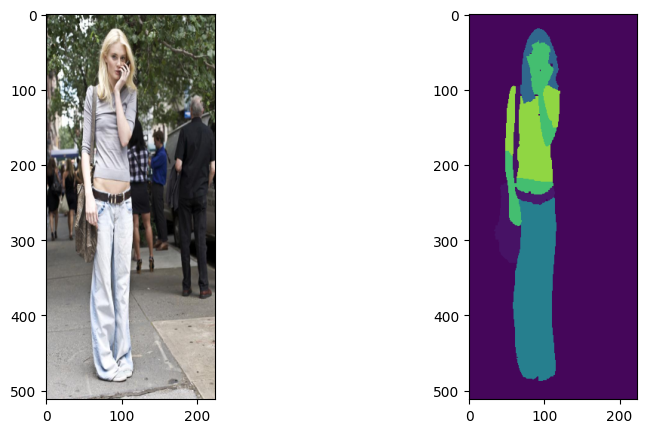

In [18]:
from matplotlib import pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

dataset = CustomClothingDataset(root_dir=DATASET_DIR,
                                transform_input=transforms.Compose([
                     transforms.Resize((512, 224)), #size mayor de las imagenes, para todas iguales sin perder información
                 ]),
                                transform_labels=transforms.Compose([transforms.Resize((512, 224), interpolation=InterpolationMode.NEAREST_EXACT)                                                                  
    ])
                                )
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
print("Cantidad de imágenes: ", len(data_loader.dataset))

for image, label in data_loader:
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(image[0].int(), (1, 2, 0)))
    plt.subplot(1, 2, 2)
    print(label[0].shape)
    plt.imshow(decode_image(label[0]))
    plt.show()
    break

## Implementación 1
### Modelo U-NET

Creación del modelo:

Hay que coger imagenes con el mismo grosor y altura para meterlos como input en la u-net, no vale `877x550` sino al mejor `560x560` para evitar coger el mayor porque puede generar ruido en la imagen, y tambien porque ese valor es divisible por 2 para pooling y unpooling, se prefiere compactarlo que generar ruido.

In [19]:
import torch
import torch.nn as nn

""" Convolutional block:
    It follows a two 3x3 convolutional layer, each followed by a batch normalization and a relu activation.
"""
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

""" Encoder block:
    It consists of an conv_block followed by a max pooling.
    Here the number of filters doubles and the height and width half after every block.
"""
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

""" Decoder block:
    The decoder block begins with a transpose convolution, followed by a concatenation with the skip
    connection from the encoder block. Next comes the conv_block.
    Here the number filters decreases by half and the height and width doubles.
"""
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x


class build_unet(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(3, 70)
        self.e2 = encoder_block(70, 140)
        self.e3 = encoder_block(140, 280)
        self.e4 = encoder_block(280, 560)

        """ Bottleneck """
        self.b = conv_block(560, 1120)

        """ Decoder """
        self.d1 = decoder_block(1120, 560)
        self.d2 = decoder_block(560, 280)
        self.d3 = decoder_block(280, 140)
        self.d4 = decoder_block(140, 70)

        """ Classifier """
        self.outputs = nn.Conv2d(70, 59, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        """ Classifier """
        outputs = self.outputs(d4)

        return outputs


#inputs = torch.randn((2, 3, 560, 560)).to(device)
inputs = torch.randn((4, 3, 576, 576))#.to(device)
model = build_unet()#.to(device)
y = model(inputs)
print(y.shape)

torch.Size([4, 59, 576, 576])


In [20]:
from torch.utils.data import random_split

BATCH_SIZE = 8
EPOCHS = 10
dataset = CustomClothingDataset(root_dir=DATASET_DIR) 
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE)
full_dataset = CustomClothingDataset(root_dir=DATASET_DIR)

train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

loss_fn = torch.nn.CrossEntropyLoss()


In [21]:
import pandas as pd
import torch
from matplotlib import pyplot as plt


class EarlyStopper:
    def __init__(self, patience=2, min_delta=0.1):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


class ModelTrainer:

    def __init__(self, model, optimizer, loss_fn, epochs, early_stopper, device):
        self.device = device
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.epochs = epochs
        self.result = pd.DataFrame(columns=["Epoch", "train_loss", "train_acc", "val_loss", "val_acc"])
        self.early_stopper = early_stopper

    def train_and_val(self, training_loader, val_loader, silent=False):
        for i in range(1, self.epochs + 1):
            train_loss, train_acc = self.train(training_loader)
            val_loss, val_acc = self.validate(val_loader)
            self.result.loc[len(self.result)] = (i,) + (train_loss, train_acc) + (val_loss, val_acc)
            if not silent:
                print("Epoch: " + str(i) + ", Train acc: " + str(train_acc) + ", loss: " + str(
                    train_loss) + " //// Val acc: " + str(val_acc) + " loss: " + str(val_loss))
            if self.early_stopper.early_stop(val_loss):
                self.epochs = i + 1
                break

    def train(self, training_loader):
        running_loss = 0.
        acc_sum = 0
        self.model.train()
        for i, data in enumerate(training_loader):
            # Every data instance is an input + label pair
            inputs, labels = data[0].to(self.device), data[1].to(self.device)
            # Make predictions for this batch
            outputs = self.model(inputs).to(self.device)
            # Compute the loss and its gradients
            loss = self.loss_fn(outputs, torch.argmax(labels, dim=1))
            loss.backward()
            # Adjust learning weights
            self.optimizer.step()
            # Zero your gradients for every batch!
            self.optimizer.zero_grad()
            # Gather data and report
            running_loss += loss.item()
            acc_sum += (outputs.argmax(1) == torch.argmax(labels, dim=1)).type(torch.float).sum().item() / (512 * 224)
  
        train_loss = running_loss / len(training_loader)  # perdida media de la época por batch
        acc = 100 * (acc_sum / len(training_loader.dataset))  # acc media de la época
        return train_loss, acc

    def validate(self, val_loader):
        self.model.eval()
        val_loss, correct = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                val_loss += self.loss_fn(outputs, torch.argmax(labels, dim=1)).item()
                correct += (outputs.argmax(1) == torch.argmax(labels, dim=1)).type(torch.float).sum().item() / (512 * 224)
        val_loss /= len(val_loader)
        val_acc = 100 * correct / len(val_loader.dataset)
        return val_loss, val_acc

    def draw_results(self):
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(self.result["Epoch"], self.result["train_loss"], label='Training Loss', marker='o')
        plt.plot(self.result["Epoch"], self.result["val_loss"], label='Validation Loss', marker='o')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Loss')
        # Plotting Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(self.result["Epoch"], self.result["train_acc"], label='Training Accuracy', marker='o')
        plt.plot(self.result["Epoch"], self.result["val_acc"], label='Validation Accuracy', marker='o')
        plt.xlabel('Epoch')
        plt.ylim(40, 100)
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Training and Validation Accuracy')
        # Adjust layout to prevent overlap
        plt.tight_layout()
        # Show the plot
        plt.show()

    def test(self, test_loader):
        self.model.eval()
        test_loss, correct = 0, 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                test_loss += self.loss_fn(outputs, labels).item()
                correct += (outputs.argmax(1) == labels.argmax(1)).type(torch.float).sum().item()
        test_loss /= len(test_loader)
        test_acc = 100 * correct / len(test_loader.dataset)
        print(f"Test Accuracy: {test_acc:>0.1f}%, Avg loss: {test_loss:>8f} \n")





Epoch: 1, Train acc: 73.40332329346, loss: 1.3063510724089362 //// Val acc: 76.94492885044642 loss: 1.0502798212201971
Epoch: 2, Train acc: 78.78049695981822, loss: 0.8576896617358382 //// Val acc: 79.34653436569941 loss: 0.8216242947076496
Epoch: 3, Train acc: 79.90231418881322, loss: 0.7908032827756621 //// Val acc: 79.58745465959822 loss: 0.8002451720990633
Epoch: 4, Train acc: 80.26463745763063, loss: 0.7566059563647617 //// Val acc: 80.58689081101191 loss: 0.7394336305166546
Epoch: 5, Train acc: 80.82985480141241, loss: 0.7266841381788254 //// Val acc: 81.50110444568453 loss: 0.7028559665930899
Epoch: 6, Train acc: 81.33481824888077, loss: 0.6968608234416355 //// Val acc: 81.02755301339285 loss: 0.7117346776159186
Epoch: 7, Train acc: 81.84312782396283, loss: 0.6745703159408136 //// Val acc: 81.13148135230655 loss: 0.7067174315452576
Epoch: 8, Train acc: 82.34647906889114, loss: 0.6463606032458219 //// Val acc: 82.2796688988095 loss: 0.6644725423110159
Epoch: 9, Train acc: 82.8729

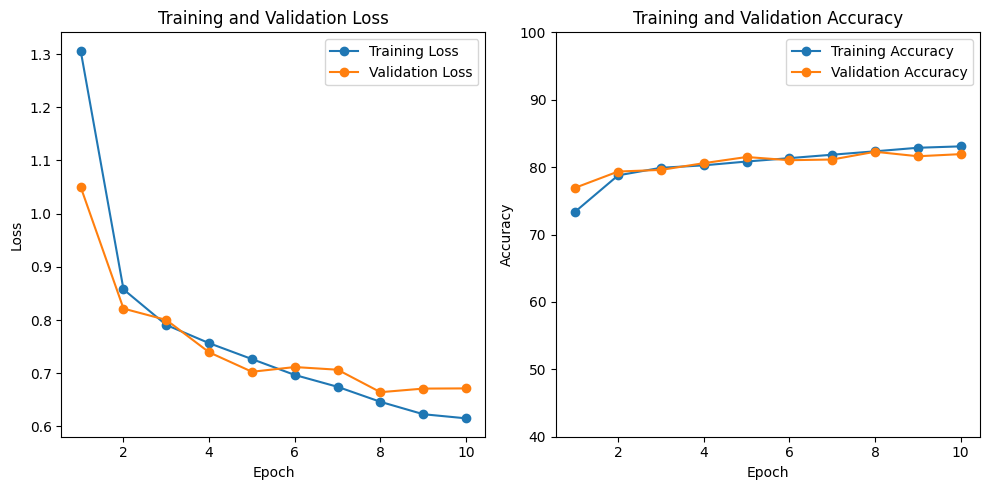

RuntimeError: Expected floating point type for target with class probabilities, got Byte

In [22]:
#from classes import ModelTrainer, EarlyStopper
device = "cuda"
model = build_unet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
#TrainNNObject = ModelTrainer(model, optimizer, loss_fn, 10, EarlyStopper(), device)
#TrainNNObject.train_and_val(train_loader, val_loader)
#TrainNNObject.draw_results()
TrainNNObject.test(test_loader)

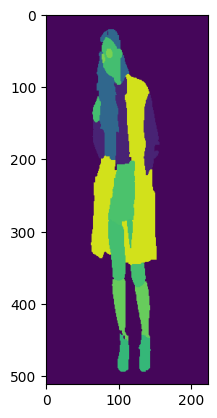

In [66]:
label = CustomClothingDataset(root_dir=DATASET_DIR).__getitem__(0)[1]
plt.imshow(decode_image(label))

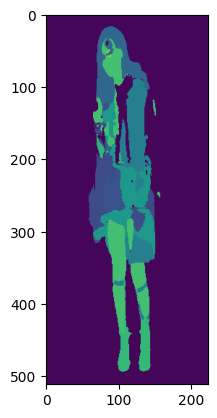

In [55]:
item = CustomClothingDataset(root_dir=DATASET_DIR).__getitem__(0)[0].to(device)

t = model(item.unsqueeze(0)).to("cpu")

a = t.argmax (1)
m = torch.zeros (t.shape, dtype=torch.uint8).scatter (1, a.unsqueeze (1), 1.0)

plt.imshow(decode_image(m[0]))